In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/AFM/'

In [4]:
import pandas as pd

n1 = pd.read_csv(path + 'NIFTY 50_Historical_PR_29112020to28112021.csv', index_col=0, parse_dates=True)
n2 = pd.read_csv(path + 'NIFTY 50_Historical_PR_29112021to28112022.csv', index_col=0, parse_dates=True)
n3 = pd.read_csv(path + 'NIFTY 50_Historical_PR_29112022to28112023.csv', index_col=0, parse_dates=True)
n4 = pd.read_csv(path + 'NIFTY 50_Historical_PR_29112023to28112024.csv', index_col=0, parse_dates=True)
n5 = pd.read_csv(path + 'NIFTY 50_Historical_PR_29112024to29112025.csv', index_col=0, parse_dates=True)

prices = pd.concat([n1, n2, n3, n4, n5]).sort_index()
prices = prices[['Close']].rename(columns={'Close':'NIFTY'})

In [14]:
import pandas as pd
import numpy as np

def load_ff(path):
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()

    clean = []
    for line in lines:
        parts = line.strip().split(',')
        if parts[0].isdigit() and len(parts[0]) == 8:
            clean.append(line)

    from io import StringIO
    temp = pd.read_csv(StringIO(''.join(clean)), header=None)

    cols = ['DATE'] + [f'X{i}' for i in range(temp.shape[1]-1)]
    temp.columns = cols

    temp['DATE'] = pd.to_datetime(temp['DATE'], format='%Y%m%d', errors='coerce')
    temp = temp.dropna(subset=['DATE']).set_index('DATE')

    return temp.apply(pd.to_numeric, errors='coerce')

In [15]:
ff = load_ff(path + 'F-F_Research_Data_Factors_daily.csv') / 100
mom = load_ff(path + 'F-F_Momentum_Factor_daily.csv') / 100
dgs = pd.read_csv(path + 'DGS10.csv', index_col=0, parse_dates=True)

In [16]:
ff.head(), mom.head(), dgs.head(), prices.head()

(                X0      X1      X2      X3
 DATE                                      
 1926-07-01  0.0009 -0.0025 -0.0027  0.0001
 1926-07-02  0.0045 -0.0033 -0.0006  0.0001
 1926-07-06  0.0017  0.0030 -0.0039  0.0001
 1926-07-07  0.0009 -0.0058  0.0002  0.0001
 1926-07-08  0.0022 -0.0038  0.0019  0.0001,
                 X0
 DATE              
 1926-11-03  0.0054
 1926-11-04 -0.0051
 1926-11-05  0.0117
 1926-11-06 -0.0003
 1926-11-08 -0.0002,
                   DGS10
 observation_date       
 2020-11-27         0.84
 2020-11-30         0.84
 2020-12-01         0.92
 2020-12-02         0.95
 2020-12-03         0.92,
                NIFTY
 Index Name          
 NIFTY 50    17026.45
 NIFTY 50    17536.25
 NIFTY 50    17415.05
 NIFTY 50    17503.35
 NIFTY 50    17416.55)

In [17]:
ff.columns

Index(['X0', 'X1', 'X2', 'X3'], dtype='object')

In [18]:
ff.columns = ['Mkt-RF','SMB','HML','RF']

In [19]:
mom.columns = ['MOM']

In [20]:
ret = prices['NIFTY'].pct_change().dropna()
rf = ff['RF'].reindex(ret.index).fillna(method='ffill')
excess = ret - rf

factors = ff[['Mkt-RF','SMB','HML']].reindex(ret.index).fillna(method='ffill')
factors['MOM'] = mom['MOM'].reindex(ret.index).fillna(method='ffill')
factors['DGS10'] = pd.to_numeric(dgs.iloc[:,0], errors='coerce').reindex(ret.index).fillna(method='ffill').pct_change().fillna(0)

merged = pd.concat([ret, excess, factors], axis=1).dropna()

/tmp/ipython-input-3440957712.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf = ff['RF'].reindex(ret.index).fillna(method='ffill')
/tmp/ipython-input-3440957712.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  factors = ff[['Mkt-RF','SMB','HML']].reindex(ret.index).fillna(method='ffill')
/tmp/ipython-input-3440957712.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  factors['MOM'] = mom['MOM'].reindex(ret.index).fillna(method='ffill')
/tmp/ipython-input-3440957712.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  factors['DGS10'] = pd.to_numeric(dgs.iloc[:,0], errors='coerce').reindex(ret.index).fillna(method='ffill').p

**MULTI FACTOR REGRESSION**

In [37]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/AFM/'
import pandas as pd, numpy as np, statsmodels.api as sm, matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.arima.model import ARIMA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
n1 = pd.read_csv(base_path + 'NIFTY 50_Historical_PR_29112020to28112021.csv', index_col=0, parse_dates=True, engine='python')
n2 = pd.read_csv(base_path + 'NIFTY 50_Historical_PR_29112021to28112022.csv', index_col=0, parse_dates=True, engine='python')
n3 = pd.read_csv(base_path + 'NIFTY 50_Historical_PR_29112022to28112023.csv', index_col=0, parse_dates=True, engine='python')
n4 = pd.read_csv(base_path + 'NIFTY 50_Historical_PR_29112023to28112024.csv', index_col=0, parse_dates=True, engine='python')
n5 = pd.read_csv(base_path + 'NIFTY 50_Historical_PR_29112024to29112025.csv', index_col=0, parse_dates=True, engine='python')
prices = pd.concat([n1, n2, n3, n4, n5]).sort_index()
if 'Close' in prices.columns:
    prices = prices[['Close']].rename(columns={'Close':'NIFTY'})
elif 'Adj Close' in prices.columns or 'Adj_Close' in prices.columns:
    col = 'Adj Close' if 'Adj Close' in prices.columns else 'Adj_Close'
    prices = prices[[col]].rename(columns={col:'NIFTY'})
else:
    prices = prices.iloc[:,[0]].rename(columns={prices.columns[0]:'NIFTY'})

In [39]:
def load_ff(path):
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()
    clean = []
    for line in lines:
        parts = line.strip().split(',')
        if len(parts)>0 and parts[0].strip().isdigit() and len(parts[0].strip())==8:
            clean.append(line)
    from io import StringIO
    temp = pd.read_csv(StringIO(''.join(clean)), header=None, engine='python')
    cols = ['DATE'] + [f'X{i}' for i in range(temp.shape[1]-1)]
    temp.columns = cols
    temp['DATE'] = pd.to_datetime(temp['DATE'], format='%Y%m%d', errors='coerce')
    temp = temp.dropna(subset=['DATE']).set_index('DATE')
    return temp.apply(pd.to_numeric, errors='coerce')
ff = load_ff(base_path + 'F-F_Research_Data_Factors_daily.csv')
mom = load_ff(base_path + 'F-F_Momentum_Factor_daily.csv')
dgs = pd.read_csv(base_path + 'DGS10.csv', index_col=0, parse_dates=True, engine='python')


In [40]:
n1.head()
n1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [41]:
def load_price(path):
    df = pd.read_csv(path, engine='python')
    date_col = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.set_index(date_col)
    if 'Close' in df.columns:
        return df[['Close']].rename(columns={'Close':'NIFTY'})
    else:
        return df.iloc[:,[1]].rename(columns={df.columns[1]:'NIFTY'})

In [43]:
def load_price(path):
    df = pd.read_csv(path, engine='python')
    date_col = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.set_index(date_col)
    if 'Close' in df.columns:
        return df[['Close']].rename(columns={'Close':'NIFTY'})
    else:
        return df.iloc[:,[1]].rename(columns={df.columns[1]:'NIFTY'})

In [44]:
p1 = load_price(base_path + 'NIFTY 50_Historical_PR_29112020to28112021.csv')
p2 = load_price(base_path + 'NIFTY 50_Historical_PR_29112021to28112022.csv')
p3 = load_price(base_path + 'NIFTY 50_Historical_PR_29112022to28112023.csv')
p4 = load_price(base_path + 'NIFTY 50_Historical_PR_29112023to28112024.csv')
p5 = load_price(base_path + 'NIFTY 50_Historical_PR_29112024to29112025.csv')

prices = pd.concat([p1,p2,p3,p4,p5]).sort_index()
prices.index = prices.index.normalize()

In [45]:
ff.columns = ['Mkt-RF','SMB','HML','RF']
mom.columns = ['MOM']

ff.index = ff.index.normalize()
mom.index = mom.index.normalize()
dgs.index = pd.to_datetime(dgs.index).normalize()

In [46]:
full_index = prices.index

ff2 = ff.reindex(full_index).fillna(method='ffill')
mom2 = mom.reindex(full_index).fillna(method='ffill')
dgs2 = dgs.reindex(full_index).fillna(method='ffill')

/tmp/ipython-input-2299025165.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ff2 = ff.reindex(full_index).fillna(method='ffill')
/tmp/ipython-input-2299025165.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mom2 = mom.reindex(full_index).fillna(method='ffill')
/tmp/ipython-input-2299025165.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dgs2 = dgs.reindex(full_index).fillna(method='ffill')


In [47]:
ret = prices['NIFTY'].pct_change().dropna()
rf = ff2['RF'].reindex(ret.index).fillna(method='ffill')
excess = ret - rf

factors = ff2[['Mkt-RF','SMB','HML']].reindex(ret.index).fillna(method='ffill')
factors['MOM'] = mom2['MOM'].reindex(ret.index).fillna(method='ffill')

dgs_col = dgs2.columns[0]
factors['DGS10'] = pd.to_numeric(dgs2[dgs_col], errors='coerce').pct_change().reindex(ret.index).fillna(0)

merged = pd.concat([ret.rename('Return'), excess.rename('Excess'), factors], axis=1).dropna()


/tmp/ipython-input-1788802477.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf = ff2['RF'].reindex(ret.index).fillna(method='ffill')
/tmp/ipython-input-1788802477.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  factors = ff2[['Mkt-RF','SMB','HML']].reindex(ret.index).fillna(method='ffill')
/tmp/ipython-input-1788802477.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  factors['MOM'] = mom2['MOM'].reindex(ret.index).fillna(method='ffill')


In [48]:
merged.shape, merged.head()

((1239, 7),
               Return    Excess  Mkt-RF   SMB   HML   MOM     DGS10
 Date                                                              
 2020-12-02  0.000359  0.000359    0.11 -0.09  1.07 -2.23  0.032609
 2020-12-03  0.001537  0.001537    0.17  0.51 -0.10 -0.56 -0.031579
 2020-12-04  0.009491  0.009491    1.01  1.47  0.83 -1.85  0.054348
 2020-12-07  0.007331  0.007331    0.02  0.24 -1.02  1.53 -0.030928
 2020-12-08  0.002785  0.002785    0.47  1.01 -0.69  0.14 -0.021277)

In [49]:
y = merged['Excess']
X = sm.add_constant(merged[['Mkt-RF','SMB','HML','MOM','DGS10']])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Excess   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     6.917
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.22e-06
Time:                        10:33:08   Log-Likelihood:                 3648.1
No. Observations:                1239   AIC:                            -7284.
Df Residuals:                    1233   BIC:                            -7253.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0122      0.000    -33.594      0.000      -0.013      -0.012
Mkt-RF         0.0017      0.000      4.576      0.000       0.001       0.002
SMB            0.0002      0.001      0.434      0.665      -0.001       0.001
HML            0.0008      0.000      1.916      0.056   -1.96e-05       0.002
MOM        -8.314e-05      0.000     -0.236      0.813      -0.001       0.001
DGS10          0.0445      0.017      2.557      0.011       0.010       0.079
==============================================================================
Omnibus:                       35.365   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.160
Skew:                           0.380   Prob(JB):                     3.14e-09
Kurtosis:                       3.425   Cond. No.                         61.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Cumulative Factor Contributions**

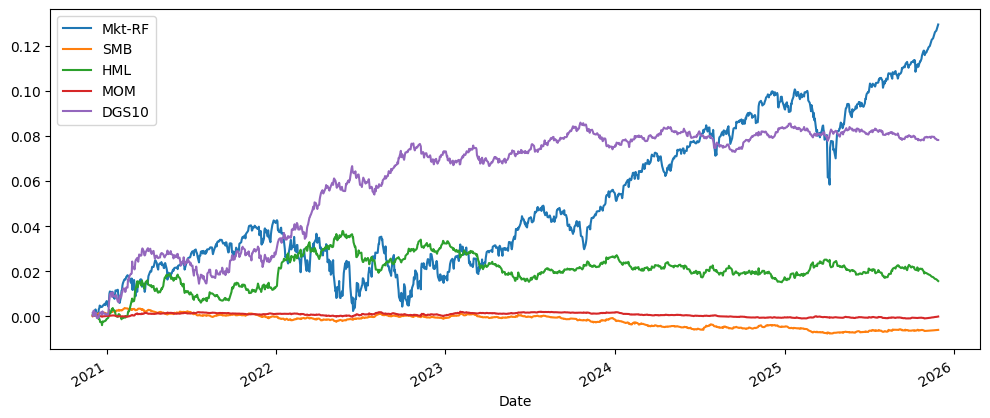

In [50]:
factor_returns = merged[['Mkt-RF','SMB','HML','MOM','DGS10']]
cum_contrib = (factor_returns.multiply(model.params[1:], axis=1)).cumsum()
cum_contrib.plot(figsize=(12,5))
plt.show()

**Rolling Residual Volatility**

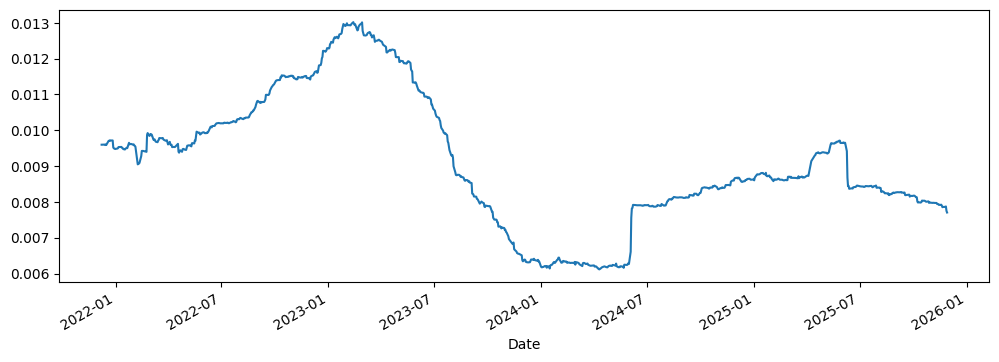

In [51]:
residuals = model.resid.reindex(merged.index)
roll_resid_vol = residuals.rolling(252).std()
roll_resid_vol.plot(figsize=(12,4))
plt.show()

**Correlation Heatmap**

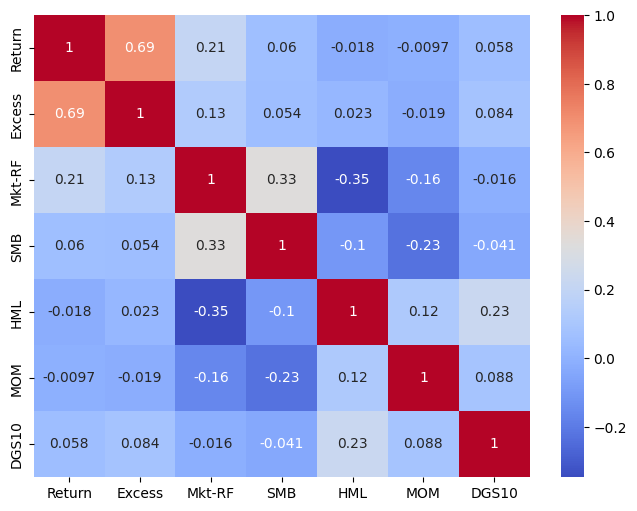

In [52]:
import seaborn as sns
corr = merged.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Actual vs ARIMA vs LSTM 6 Month Forecast**

In [55]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(prices['NIFTY'].dropna(), order=(5,1,0)).fit()
arima_fc = arima_model.get_forecast(steps=30)
arima_pred = arima_fc.predicted_mean

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

series = prices['NIFTY'].dropna().values.reshape(-1,1)
scaler = StandardScaler()
s = scaler.fit_transform(series)

X_l = []
y_l = []
seq = 60
for i in range(seq, len(s)):
    X_l.append(s[i-seq:i,0])
    y_l.append(s[i,0])

X_l = np.array(X_l).reshape(-1,seq,1)
y_l = np.array(y_l)

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq,1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_l, y_l, epochs=10, batch_size=32, verbose=1)

pred_scaled = model_lstm.predict(X_l[-30:])
pred = scaler.inverse_transform(pred_scaled)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.2936
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0161
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0136
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0119
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0110
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0112
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0095
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0098
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0093
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


In [58]:
actual = prices['NIFTY'].iloc[-200:]

future_index = pd.date_range(start=actual.index[-1] + pd.Timedelta(days=1),
                             periods=30, freq='D')

lstm_series = pd.Series(pred.flatten(), index=future_index)


In [59]:
arima_series = arima_pred
arima_series.index = future_index

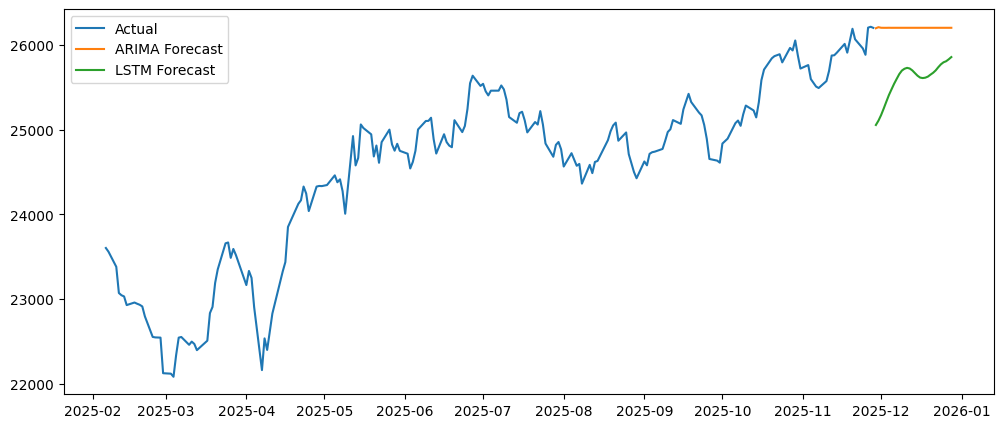

In [60]:
plt.figure(figsize=(12,5))
plt.plot(actual, label='Actual')
plt.plot(arima_series, label='ARIMA Forecast')
plt.plot(lstm_series, label='LSTM Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

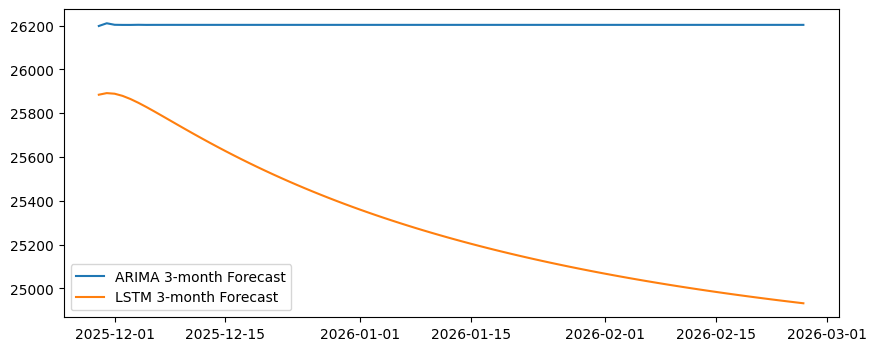

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

future_index_90 = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

arima_model = ARIMA(prices['NIFTY'].dropna(), order=(5,1,0)).fit()
arima_pred_90 = arima_model.get_forecast(steps=90).predicted_mean
arima_series_90 = pd.Series(arima_pred_90.values, index=future_index_90)

seq = 60
last_seq = scaler.transform(prices['NIFTY'].dropna().values.reshape(-1,1))[-seq:,0].copy()
preds_scaled = []
for _ in range(90):
    x = last_seq.reshape(1,seq,1)
    next_scaled = model_lstm.predict(x, verbose=0)[0,0]
    preds_scaled.append(next_scaled)
    last_seq = np.append(last_seq[1:], next_scaled)
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
lstm_series_90 = pd.Series(preds, index=future_index_90)

plt.figure(figsize=(10,4))
plt.plot(arima_series_90, label='ARIMA 3-month Forecast')
plt.plot(lstm_series_90, label='LSTM 3-month Forecast')
plt.legend()
plt.show()

**Previous 3 Month vs Next 3 Month Forecast Split Plot**

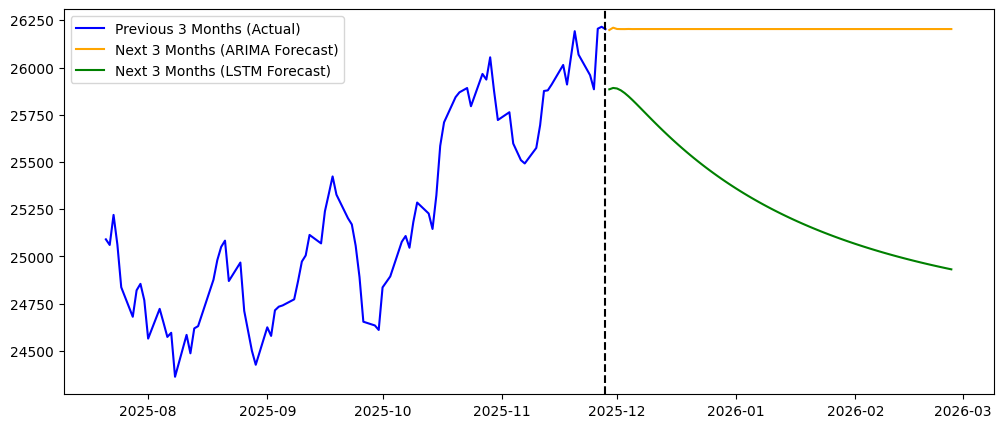

In [62]:
past_3m = prices['NIFTY'].iloc[-90:]

future_dates = future_index_90[:90]
arima_next3 = arima_series_90[:90]
lstm_next3 = lstm_series_90[:90]

plt.figure(figsize=(12,5))
plt.plot(past_3m, label='Previous 3 Months (Actual)', color='blue')
plt.plot(future_dates, arima_next3, label='Next 3 Months (ARIMA Forecast)', color='orange')
plt.plot(future_dates, lstm_next3, label='Next 3 Months (LSTM Forecast)', color='green')
plt.axvline(past_3m.index[-1], color='black', linestyle='--')

plt.legend()
plt.show()

**RISK ANALYSIS:**

/tmp/ipython-input-1746785049.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-1746785049.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-1746785049.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-1746785049.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

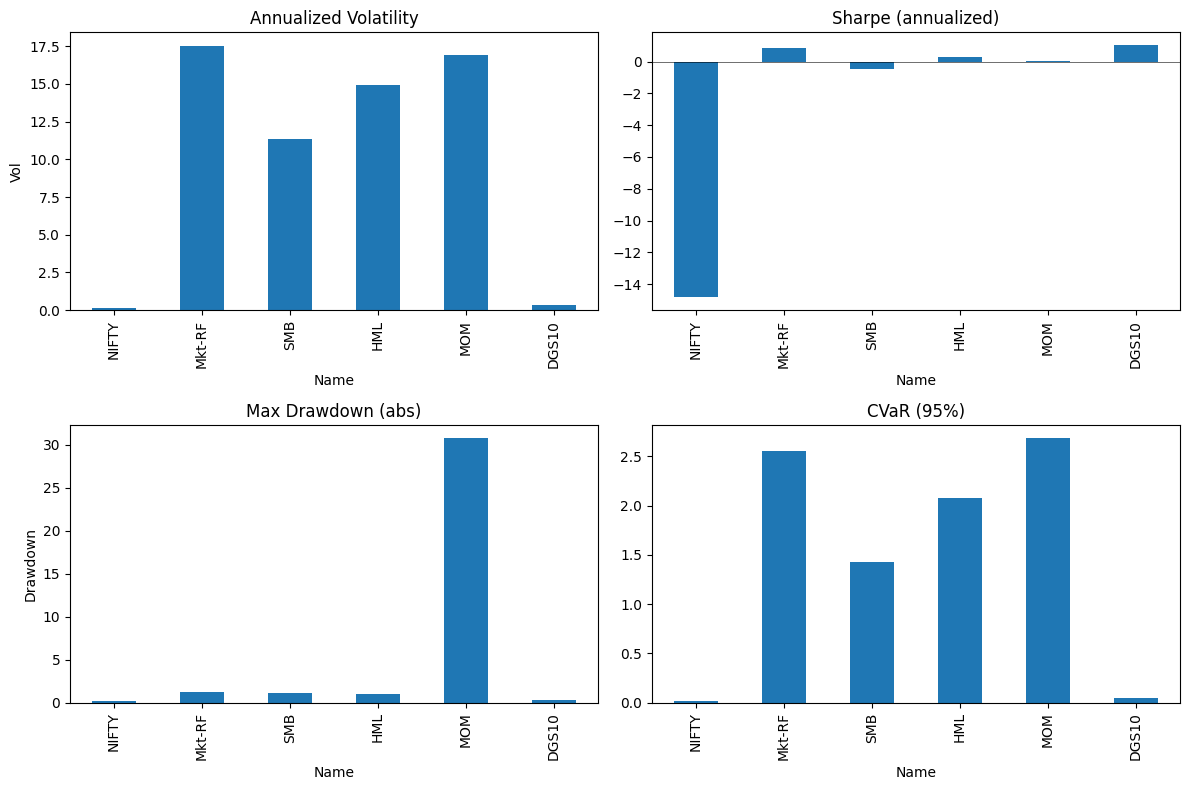

,AnnReturn,AnnVol,Sharpe,MaxDD,VaR95,CVaR95,Beta
Name,,,,,,,
NIFTY,0.150789,0.140488,-14.841625,-0.172298,0.013596,0.020290,0.001668
Mkt-RF,15.492203,17.549730,0.882760,-1.226260,1.740000,2.555079,1.000000
SMB,-5.198644,11.379267,-0.456852,-1.169322,1.141000,1.422742,0.217098
HML,3.915254,14.959721,0.261720,-1.020000,1.442000,2.071774,-0.295988
MOM,0.341695,16.947227,0.020162,-30.791233,1.841000,2.684839,-0.152716
DGS10,0.357297,0.341644,1.045816,-0.316092,0.032373,0.045093,-0.000303


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

series_dict = {}
series_dict['NIFTY'] = merged['Return']
for f in ['Mkt-RF','SMB','HML','MOM','DGS10']:
    series_dict[f] = merged[f]

def ann_ret(r):
    return r.mean() * 252

def ann_vol(r):
    return r.std(ddof=0) * np.sqrt(252)

def sharpe_excess(r_excess):
    return r_excess.mean() / r_excess.std(ddof=0) * np.sqrt(252)

def max_drawdown(series):
    cr = (1+series).cumprod()
    peak = cr.cummax()
    dd = (cr - peak) / peak
    return dd.min()

def hist_var(r, p=0.95):
    q = np.quantile(r, 1-p)
    return -q

def cvar(r, p=0.95):
    q = np.quantile(r, 1-p)
    return -r[r<=q].mean() if (r<=q).any() else -q

def beta_to_market(r, market):
    ok = (~r.isna()) & (~market.isna())
    y = r[ok]
    X = sm.add_constant(market[ok])
    try:
        res = sm.OLS(y, X).fit()
        return res.params[1]
    except:
        return np.nan

metrics = []
market_series = merged['Mkt-RF']
for name, s in series_dict.items():
    if name == 'NIFTY':
        excess_for_sharpe = merged['Excess']
    else:
        excess_for_sharpe = s
    ar = ann_ret(s)
    av = ann_vol(s)
    sr = sharpe_excess(excess_for_sharpe)
    md = max_drawdown(s)
    var95 = hist_var(s, 0.95)
    cvar95 = cvar(s, 0.95)
    b = beta_to_market(s, market_series)
    metrics.append({'Name':name,'AnnReturn':ar,'AnnVol':av,'Sharpe':sr,'MaxDD':md,'VaR95':var95,'CVaR95':cvar95,'Beta':b})

dfm = pd.DataFrame(metrics).set_index('Name')

fig, axes = plt.subplots(2,2, figsize=(12,8))
dfm['AnnVol'].plot(kind='bar', ax=axes[0,0], title='Annualized Volatility')
axes[0,0].set_ylabel('Vol')
dfm['Sharpe'].plot(kind='bar', ax=axes[0,1], title='Sharpe (annualized)')
axes[0,1].axhline(0, color='k', linewidth=0.4)
dfm['MaxDD'].abs().plot(kind='bar', ax=axes[1,0], title='Max Drawdown (abs)')
axes[1,0].set_ylabel('Drawdown')
dfm['CVaR95'].plot(kind='bar', ax=axes[1,1], title='CVaR (95%)')
plt.tight_layout()
plt.savefig('competitive_risk_summary.png', dpi=150, bbox_inches='tight')
plt.show()

display_df = dfm.round(6)
display_df

/tmp/ipython-input-2712240994.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y[ok], sm.add_constant(market[ok])).fit().params[1]
/tmp/ipython-input-2712240994.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y[ok], sm.add_constant(market[ok])).fit().params[1]
/tmp/ipython-input-2712240994.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y[ok], sm.add_constant(market[ok])).fit()

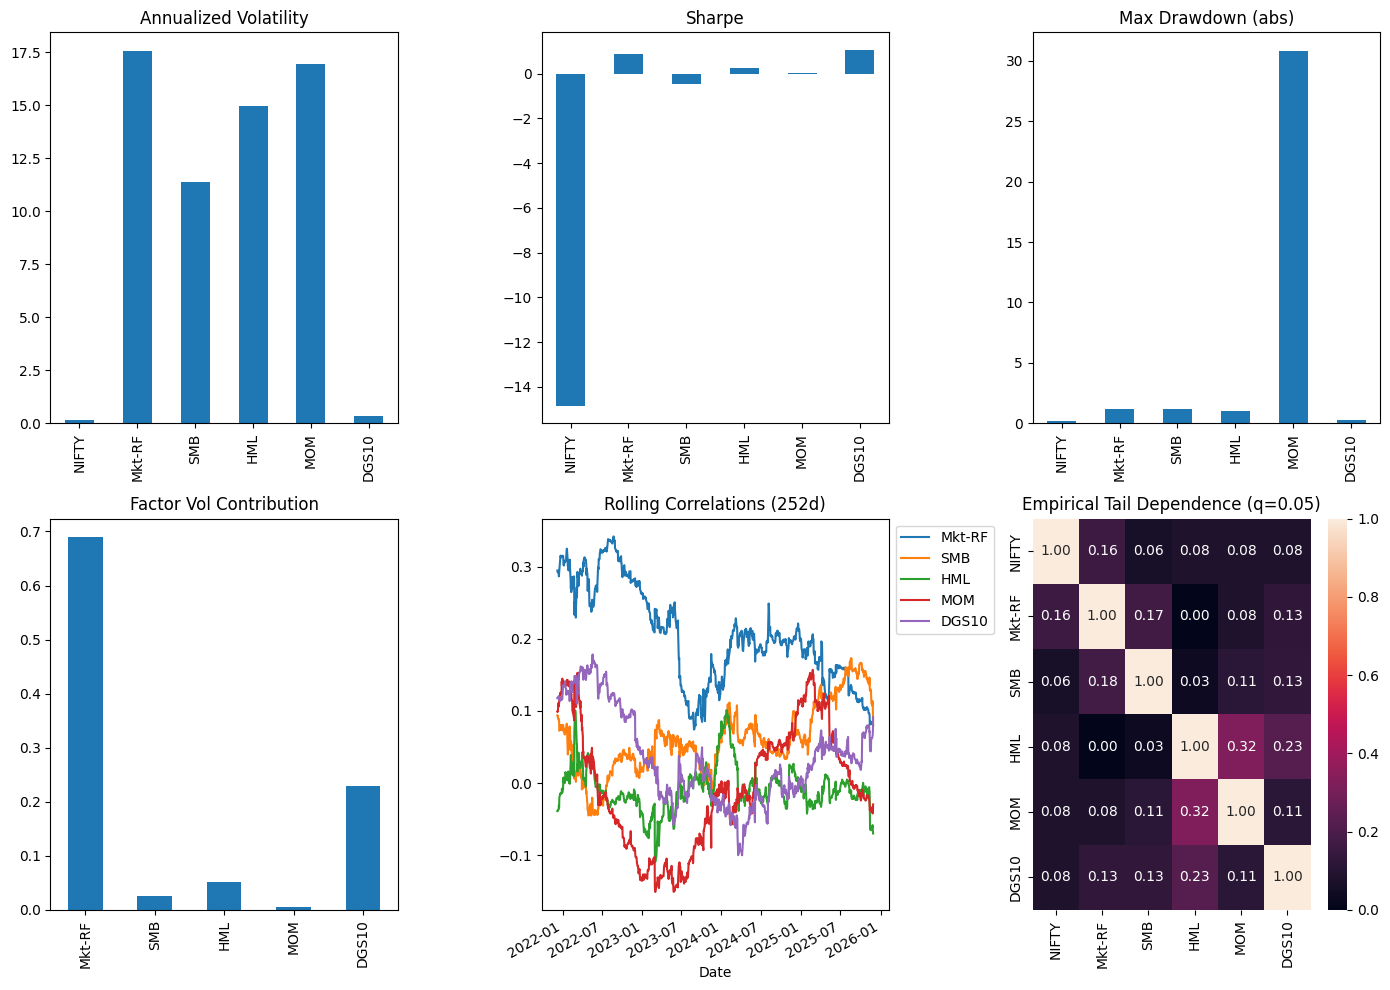

Metrics Table


,AnnReturn,AnnVol,Sharpe,MaxDD,VaR95,CVaR95,Beta
NIFTY,0.150789,0.140488,-14.841625,-0.172298,0.013596,0.020290,0.001668
Mkt-RF,15.492203,17.549730,0.882760,-1.226260,1.740000,2.555079,1.000000
SMB,-5.198644,11.379267,-0.456852,-1.169322,1.141000,1.422742,0.217098
HML,3.915254,14.959721,0.261720,-1.020000,1.442000,2.071774,-0.295988
MOM,0.341695,16.947227,0.020162,-30.791233,1.841000,2.684839,-0.152716
DGS10,0.357297,0.341644,1.045816,-0.316092,0.032373,0.045093,-0.000303



GPD params for left tail (shape, loc, scale): (np.float64(0.6137894687291694), np.float64(9.76365886954523e-10), np.float64(0.0046497341786156865))

CDaR95 (95th pct of rolling max drawdowns abs): 0.17229752584963468

Stress period cumulative returns:
2022_tightening {'NIFTY': np.float64(0.10573900616858767), 'Mkt-RF': np.float64(-1.0), 'SMB': np.float64(-1.0), 'HML': np.float64(-1.0), 'MOM': np.float64(-1.0), 'DGS10': np.float64(1.506578947368423)}
2024_rally {'NIFTY': np.float64(0.08804770976559384), 'Mkt-RF': np.float64(-1.0), 'SMB': np.float64(-1.0), 'HML': np.float64(-1.0), 'MOM': np.float64(-1.0000000000634124), 'DGS10': np.float64(0.18041237113401976)}


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
import statsmodels.api as sm

factors = ['Mkt-RF','SMB','HML','MOM','DGS10']
rets = merged['Return']
excess = merged['Excess']

def emp_tail_dependence(x, y, q=0.05):
    thresh_x = np.quantile(x, q)
    thresh_y = np.quantile(y, q)
    num = np.sum((x <= thresh_x) & (y <= thresh_y))
    den = np.sum(x <= thresh_x)
    return num/den if den>0 else np.nan

def max_drawdown(series):
    cr = (1+series).cumprod()
    peak = cr.cummax()
    dd = (cr-peak)/peak
    return dd.min()

results = {}

for name in ['NIFTY'] + factors:
    if name=='NIFTY':
        s = rets
    else:
        s = merged[name]
    ann_ret = s.mean()*252
    ann_vol = s.std(ddof=0)*np.sqrt(252)
    sharpe = excess.mean()/excess.std(ddof=0)*np.sqrt(252) if name=='NIFTY' else s.mean()/s.std(ddof=0)*np.sqrt(252)
    md = max_drawdown(s)
    var95 = -np.quantile(s,0.05)
    cvar95 = -s[s<=np.quantile(s,0.05)].mean() if np.sum(s<=np.quantile(s,0.05))>0 else var95
    if name=='NIFTY':
        market = merged['Mkt-RF']
        y = s
    else:
        market = merged['Mkt-RF']
        y = s
    ok = (~y.isna()) & (~market.isna())
    try:
        beta = sm.OLS(y[ok], sm.add_constant(market[ok])).fit().params[1]
    except:
        beta = np.nan
    results[name] = {'AnnReturn':ann_ret,'AnnVol':ann_vol,'Sharpe':sharpe,'MaxDD':md,'VaR95':var95,'CVaR95':cvar95,'Beta':beta}

df_metrics = pd.DataFrame(results).T

neg_excess = rets - rets.mean()
left_tail = -np.sort(-neg_excess[neg_excess<0])
if len(left_tail)>=20:
    thresh = np.quantile(neg_excess,0.05)
    excess_left = -neg_excess[neg_excess<0]
    params = genpareto.fit(excess_left - excess_left.min()+1e-9)
else:
    params = (np.nan,np.nan,np.nan)

roll_window = 252
rolling_corrs = pd.DataFrame(index=merged.index[roll_window-1:], columns=factors)
for f in factors:
    rolling_corrs[f] = merged['Return'].rolling(roll_window).corr(merged[f]).iloc[roll_window-1:]

rolling_betas = pd.DataFrame(index=merged.index[roll_window-1:], columns=factors)
for i in range(roll_window, len(merged)+1):
    ys = merged['Excess'].iloc[i-roll_window:i]
    xs = merged[factors].iloc[i-roll_window:i]
    res = sm.OLS(ys, sm.add_constant(xs)).fit()
    rolling_betas.iloc[i-roll_window] = res.params[1:]

roll_drawdowns = []
for i in range(0, len(merged)-roll_window+1, roll_window//12):
    s = merged['Return'].iloc[i:i+roll_window]
    roll_drawdowns.append(max_drawdown(s))
roll_drawdowns = np.array(roll_drawdowns)
cdar95 = np.percentile(np.abs(roll_drawdowns),95)

cov_f = merged[factors].cov()
betas = model.params[factors].values
var_f = betas @ cov_f.values @ betas
contrib = betas * (cov_f.values @ betas)
contrib_pct = contrib/var_f

tail_dep = pd.DataFrame(index=['NIFTY']+factors, columns=['NIFTY']+factors, dtype=float)
for a in ['NIFTY']+factors:
    for b in ['NIFTY']+factors:
        if a=='NIFTY':
            xa = rets
        else:
            xa = merged[a]
        if b=='NIFTY':
            xb = rets
        else:
            xb = merged[b]
        tail_dep.loc[a,b] = emp_tail_dependence(xa, xb, q=0.05)

stress_periods = {'2022_tightening':('2022-01-01','2023-06-30'),'2020_pandemic':('2020-02-01','2020-06-30'),'2024_rally':('2024-01-01','2024-12-31')}
stress_res = {}
for k,(s,e) in stress_periods.items():
    seg = merged.loc[s:e]
    if len(seg)>0:
        cum_nifty = (1+seg['Return']).prod()-1
        cum_f = {}
        for f in factors:
            cum_f[f] = (1+seg[f]).prod()-1
        stress_res[k] = {'NIFTY':cum_nifty, **cum_f}

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(231)
df_metrics['AnnVol'].plot(kind='bar', ax=ax1); ax1.set_title('Annualized Volatility')
ax2 = fig.add_subplot(232)
df_metrics['Sharpe'].plot(kind='bar', ax=ax2); ax2.set_title('Sharpe')
ax3 = fig.add_subplot(233)
df_metrics['MaxDD'].abs().plot(kind='bar', ax=ax3); ax3.set_title('Max Drawdown (abs)')
ax4 = fig.add_subplot(234)
pd.Series(contrib_pct,index=factors).plot(kind='bar', ax=ax4); ax4.set_title('Factor Vol Contribution')
ax5 = fig.add_subplot(235)
rolling_corrs.plot(ax=ax5); ax5.set_title('Rolling Correlations (252d)')
ax5.legend(loc='upper left', bbox_to_anchor=(1,1))
ax6 = fig.add_subplot(236)
sns.heatmap(tail_dep.astype(float), annot=True, fmt='.2f', ax=ax6); ax6.set_title('Empirical Tail Dependence (q=0.05)')
plt.tight_layout()
plt.savefig('advanced_risk_summary.png', bbox_inches='tight', dpi=150)
plt.show()

print('Metrics Table')
display(df_metrics.round(6))
print('\nGPD params for left tail (shape, loc, scale):', params)
print('\nCDaR95 (95th pct of rolling max drawdowns abs):', cdar95)
print('\nStress period cumulative returns:')
for k,v in stress_res.items():
    print(k, v)


/tmp/ipython-input-371818301.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-371818301.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-371818301.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params[1]
/tmp/ipython-input-371818301.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ver

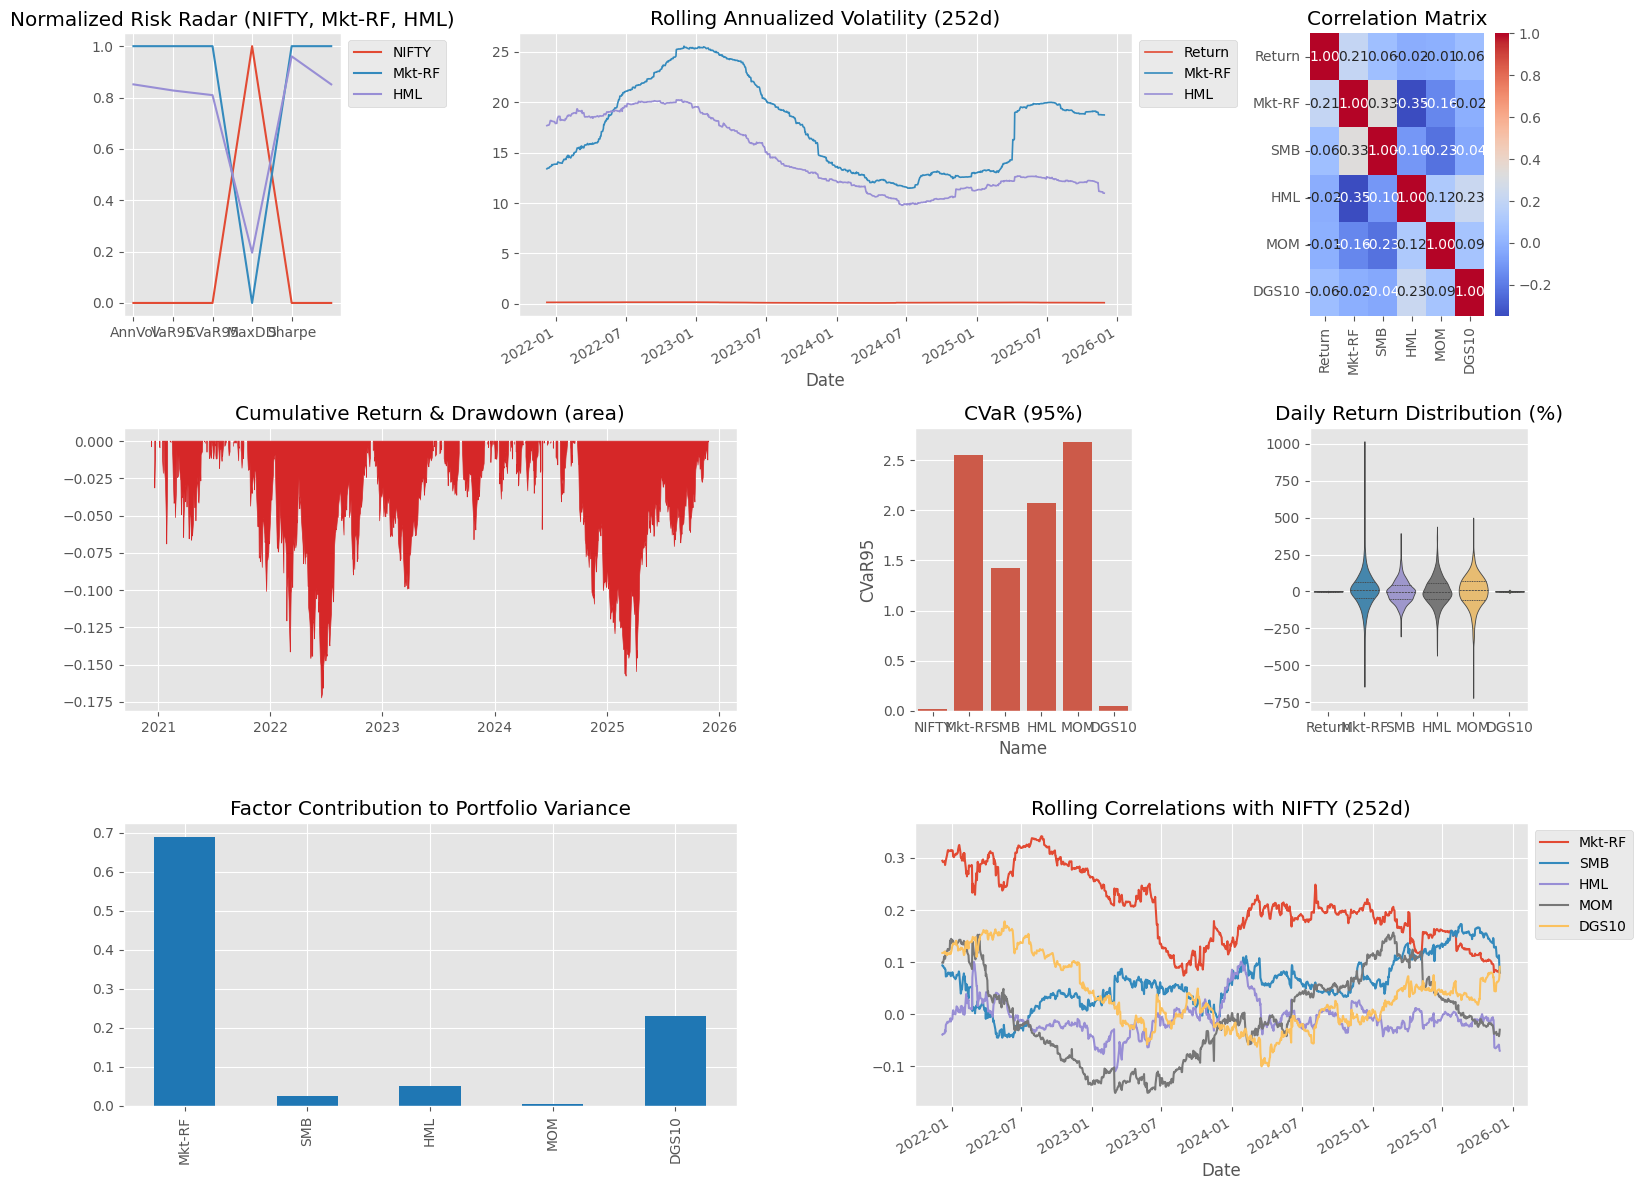

saved advanced_risk_dashboard.png


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import genpareto

try:
    plt.style.use('seaborn-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn')
    except Exception:
        plt.style.use('ggplot')

factors = ['Mkt-RF','SMB','HML','MOM','DGS10']
rets = merged['Return']
excess = merged['Excess']

def ann_ret(r): return r.mean()*252
def ann_vol(r): return r.std(ddof=0)*np.sqrt(252)
def sharpe_excess(r_excess): return r_excess.mean()/r_excess.std(ddof=0)*np.sqrt(252)
def max_drawdown(series):
    cr = (1+series).cumprod()
    peak = cr.cummax()
    dd = (cr-peak)/peak
    return dd.min()
def hist_var(r, p=0.95): return -np.quantile(r,1-p)
def cvar(r, p=0.95):
    q = np.quantile(r,1-p)
    return -r[r<=q].mean() if (r<=q).any() else -q
def beta_to_market(r, market):
    ok = (~r.isna()) & (~market.isna())
    y = r[ok]
    X = sm.add_constant(market[ok])
    try:
        res = sm.OLS(y, X).fit()
        return res.params[1]
    except:
        return np.nan

metrics = []
market_series = merged['Mkt-RF']
for name in ['NIFTY'] + factors:
    s = rets if name=='NIFTY' else merged[name]
    excess_for_sharpe = merged['Excess'] if name=='NIFTY' else s
    metrics.append({
        'Name':name,
        'AnnReturn':ann_ret(s),
        'AnnVol':ann_vol(s),
        'Sharpe':sharpe_excess(excess_for_sharpe),
        'MaxDD':max_drawdown(s),
        'VaR95':hist_var(s,0.95),
        'CVaR95':cvar(s,0.95),
        'Beta':beta_to_market(s, market_series)
    })
dfm = pd.DataFrame(metrics).set_index('Name')

roll_window = 252
rolling_vol = merged[['Return']+factors].rolling(roll_window).std().dropna()*np.sqrt(252)
rolling_corrs = pd.DataFrame({f:merged['Return'].rolling(roll_window).corr(merged[f]) for f in factors}).dropna()
rolling_r2 = []
idx = merged.index[roll_window-1:]
for i in range(roll_window, len(merged)+1):
    ys = merged['Excess'].iloc[i-roll_window:i]
    xs = merged[factors].iloc[i-roll_window:i]
    res = sm.OLS(ys, sm.add_constant(xs)).fit()
    rolling_r2.append(res.rsquared)
rolling_r2 = pd.Series(rolling_r2, index=idx)

cov_f = merged[factors].cov()
betas = model.params[factors].values
port_var = betas @ cov_f.values @ betas
contrib = betas * (cov_f.values @ betas)
contrib_pct = pd.Series(contrib/port_var, index=factors)

neg = merged['Return'][merged['Return']<0]
excess_left = -neg.values
gpd_params = (np.nan,np.nan,np.nan)
if len(excess_left)>=20:
    excess_left_shift = excess_left - excess_left.min() + 1e-9
    gpd_params = genpareto.fit(excess_left_shift)

tail_dep = pd.DataFrame(index=['NIFTY']+factors, columns=['NIFTY']+factors, dtype=float)
for a in ['NIFTY']+factors:
    for b in ['NIFTY']+factors:
        xa = rets if a=='NIFTY' else merged[a]
        xb = rets if b=='NIFTY' else merged[b]
        q=0.05
        tx = np.quantile(xa,q)
        ty = np.quantile(xb,q)
        denom = np.sum(xa<=tx)
        tail_dep.loc[a,b] = np.sum((xa<=tx)&(xb<=ty))/denom if denom>0 else np.nan

drawdown = (1+merged['Return']).cumprod()
peak = drawdown.cummax()
dd = (drawdown-peak)/peak

fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(3,4)

ax_radar = fig.add_subplot(gs[0,0])
rad_metrics = dfm.loc[['NIFTY','Mkt-RF','HML']][['AnnVol','VaR95','CVaR95','MaxDD','Sharpe']].copy()
rad_metrics_norm = rad_metrics.apply(lambda x: (x - x.min())/(x.max()-x.min()+1e-9), axis=0)
angles = np.linspace(0, 2*np.pi, rad_metrics_norm.shape[1]+1)
for i,row in rad_metrics_norm.iterrows():
    vals = np.append(row.values, row.values[0])
    ax_radar.plot(angles, vals, label=i)
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(rad_metrics_norm.columns)
ax_radar.set_title('Normalized Risk Radar (NIFTY, Mkt-RF, HML)')
ax_radar.legend(loc='upper left', bbox_to_anchor=(1,1))

ax_tv = fig.add_subplot(gs[0,1:3])
rolling_vol[['Return','Mkt-RF','HML']].plot(ax=ax_tv, linewidth=1.2)
ax_tv.set_title('Rolling Annualized Volatility (252d)')
ax_tv.legend(loc='upper left', bbox_to_anchor=(1,1))

ax_heat = fig.add_subplot(gs[0,3])
sns.heatmap(merged[['Return','Mkt-RF','SMB','HML','MOM','DGS10']].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax_heat)
ax_heat.set_title('Correlation Matrix')

ax_dd = fig.add_subplot(gs[1,0:2])
ax_dd.fill_between(dd.index, dd.values, 0, where=dd.values<0, color='tab:red')
ax_dd.set_title('Cumulative Return & Drawdown (area)')

ax_tail = fig.add_subplot(gs[1,2])
sns.barplot(x=dfm.index, y=dfm['CVaR95'], ax=ax_tail)
ax_tail.set_title('CVaR (95%)')

ax_violin = fig.add_subplot(gs[1,3])
sns.violinplot(data=merged[['Return','Mkt-RF','SMB','HML','MOM','DGS10']].apply(lambda x: x*100), inner='quartile', ax=ax_violin)
ax_violin.set_title('Daily Return Distribution (%)')

ax_contrib = fig.add_subplot(gs[2,0:2])
contrib_pct.plot(kind='bar', ax=ax_contrib, color='tab:blue')
ax_contrib.set_title('Factor Contribution to Portfolio Variance')

ax_rollcorr = fig.add_subplot(gs[2,2:])
rolling_corrs.plot(ax=ax_rollcorr, legend=False)
ax_rollcorr.set_title('Rolling Correlations with NIFTY (252d)')
ax_rollcorr.legend(rolling_corrs.columns, loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig('advanced_risk_dashboard.png', dpi=200, bbox_inches='tight')
plt.show()

print('saved advanced_risk_dashboard.png')